#Install libraries

In [1]:
!pip install -q torchinfo
!pip install einops
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. T

In [2]:
from datasets import load_dataset

In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchinfo import summary
from einops import rearrange, repeat
import os
import pickle
import random

In [25]:
import numpy as np
import matplotlib.pyplot as plt

#Código

##Data

In [5]:
ds = load_dataset("ylecun/mnist")#Spectograms Data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        label = self.data[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Define a transform to convert PIL images to tensors
stats = ((0.1307),(0.3081))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats,inplace=True)  # Convert PIL Image to PyTorch Tensor
])

# Update the datasets to use the transform
train_dataset = ImageDataset(ds['train'], transform=transform)
valid_dataset = ImageDataset(ds['test'], transform=transform)

In [7]:
Batch_size = 500

In [8]:
train_dl = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size=Batch_size, shuffle=False, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


##Check device

In [13]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cpu')

In [15]:
device = get_default_device()
torch.cuda.empty_cache()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

##Base

In [9]:
def funcion_perdida(x, xrec, mu, logvar, alpha = 1):
  ecm = F.mse_loss(x, xrec, reduction='sum')
  kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
  perdida = ecm + kl
  return perdida * alpha

In [10]:
class Base(nn.Module):

    def training_step(self, batch):
        images,labels = batch
        out, mu, log_variance = self(images)
        loss = funcion_perdida(images, out, mu, log_variance)
        return loss

    def validation_step(self, images):
        out, mu, log_variance = self(images)
        loss = funcion_perdida(images, out, mu, log_variance)
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['train_loss'], result['val_loss']))

##Model

In [11]:
class Encoder(nn.Module):
  def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim,
                 d_model):
    super(Encoder, self).__init__()
    self.layers = nn.ModuleList()

    in_channel = input_shape
    for out_channels, kernel_size, stride in zip(conv_filters,  conv_kernels, conv_strides):
        self.layers.append(nn.Sequential(nn.Conv2d(in_channel, out_channels, kernel_size, stride=stride,padding=1),
                                         nn.ReLU(),
                                         nn.BatchNorm2d(out_channels)))
        in_channel = out_channels

    self.bottleneck = nn.Flatten()
    self.mu = nn.Linear(d_model, latent_space_dim)
    self.log_variance = nn.Linear(d_model, latent_space_dim)

  def forward(self, x):
        for conv_layer in self.layers:
            x = conv_layer(x)
        x = self.bottleneck(x)
        return self.mu(x), self.log_variance(x)


class Decoder(nn.Module):
  def __init__(self,
                conv_filters,
                conv_kernels,
                conv_strides,
                latent_space_dim,
                d_model):
    super(Decoder, self).__init__()

    self.return_layer = nn.Linear(latent_space_dim, d_model)

    self.layers = nn.ModuleList()
    num_conv_layers = len(conv_filters)
    in_channels = conv_filters[num_conv_layers-1]

    for index in reversed(range(1, num_conv_layers)):
        index_output = index - 1
        out = conv_strides[index] - 1
        self.layers.append(nn.Sequential(nn.ConvTranspose2d(conv_filters[index], conv_filters[index_output], conv_kernels[index], stride=conv_strides[index], padding=1, output_padding=out),
                                         nn.ReLU(),
                                         nn.BatchNorm2d(conv_filters[index_output])))

    self.output_layer = nn.Sequential(nn.ConvTranspose2d(conv_filters[0], 1, conv_kernels[0], stride=conv_strides[0], padding=1),
                                      nn.Sigmoid())

  def forward(self, x):
      x = self.return_layer(x)
      x = x.view(-1, 64, 7, 7)
      for convT_layer in self.layers:
          x = convT_layer(x)
      x = self.output_layer(x)
      return x

class VAE(Base):
  def __init__(self,
                input_shape,
                conv_filters,
                conv_kernels,
                conv_strides,
                latent_space_dim,
                d_model):
    super(VAE, self).__init__()
    self.encoder_step = Encoder(input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim, d_model)
    self.decoder_step = Decoder(conv_filters, conv_kernels, conv_strides, latent_space_dim, d_model)

  def proyectar(self, x):
    mu, logvar = self.encoder_step(x)
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std
    return z

  def forward(self, x):
    mu, logvar = self.encoder_step(x)
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std
    xrec = self.decoder_step(z)
    return xrec, mu, logvar

In [16]:
in_chanel= 1
out_channels = (32, 64, 64, 64)
Kernels = (3, 3, 3, 3)
strides = (1, 2, 2, 1)
letent_space = 2
d_model = 3136 # 7*7*64
model_ac = to_device(VAE(in_chanel, out_channels, Kernels, strides, letent_space, d_model), device)

##Training

In [16]:
@torch.no_grad()
def evaluate(model_ac, val_loader):
    model_ac.eval()
    outputs = [model_ac.validation_step(batch) for batch,labels in val_loader]
    return model_ac.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
#metrics=[self._calculate_reconstruction_loss, self._calculate_kl_loss]
def try_model(epochs, lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    #torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        model.train()
        train_losses = []
        outlist = []
        batchlist = []
        lrs = []

        for batch in train_loader:

            optimizer.zero_grad()
            loss = model.training_step(batch)
            train_losses.append(loss)

            loss.backward()

            if grad_clip:
                torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()

            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
#epochs = 100
#max_lr = 0.001
#grad_clip = 0.0001
#weight_decay = 1e-4
#opt_func = torch.optim.Adam

epochs = 20
max_lr = 0.01
grad_clip = 0.0001
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [18]:
history = [evaluate(model_ac, train_dl)]
history

[{'val_loss': 482715.96875}]

In [19]:
history += try_model(epochs, max_lr, model_ac, train_dl, valid_dl,weight_decay, grad_clip,
                             opt_func=opt_func)

Epoch [0], train_loss: 302028.0625, val_loss: 280871.8750
Epoch [1], train_loss: 279485.1875, val_loss: 279164.2188
Epoch [2], train_loss: 278922.9688, val_loss: 279671.0625
Epoch [3], train_loss: 271739.5000, val_loss: 287625.8438
Epoch [4], train_loss: 266865.6250, val_loss: 295464.1875
Epoch [5], train_loss: 266170.1562, val_loss: 286884.2812
Epoch [6], train_loss: 265381.1562, val_loss: 269906.9688
Epoch [7], train_loss: 264119.8125, val_loss: 276311.8750
Epoch [8], train_loss: 263832.2188, val_loss: 264105.3438
Epoch [9], train_loss: 262903.5625, val_loss: 264061.2188
Epoch [10], train_loss: 261448.0312, val_loss: 267029.9375
Epoch [11], train_loss: 260117.8594, val_loss: 261590.3594
Epoch [12], train_loss: 258886.4531, val_loss: 263471.0000
Epoch [13], train_loss: 257526.8594, val_loss: 264136.7812
Epoch [14], train_loss: 255713.7188, val_loss: 258493.0781
Epoch [15], train_loss: 254298.5938, val_loss: 257548.8594
Epoch [16], train_loss: 252833.5312, val_loss: 256471.9531
Epoch [

In [20]:
save_path = "/content/drive/MyDrive/Data_AudioGen/weightsVAE_limpio.pth"
torch.save(model_ac.state_dict(), save_path)

##Analysis

In [18]:
saved_path = "/content/drive/MyDrive/Data_AudioGen/weightsVAE_limpio.pth"
weights = torch.load(saved_path,map_location=torch.device('cpu'))
model_ac.load_state_dict(weights)

<All keys matched successfully>

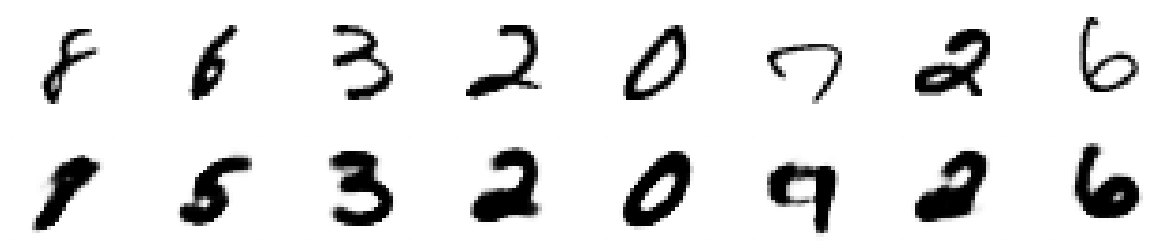

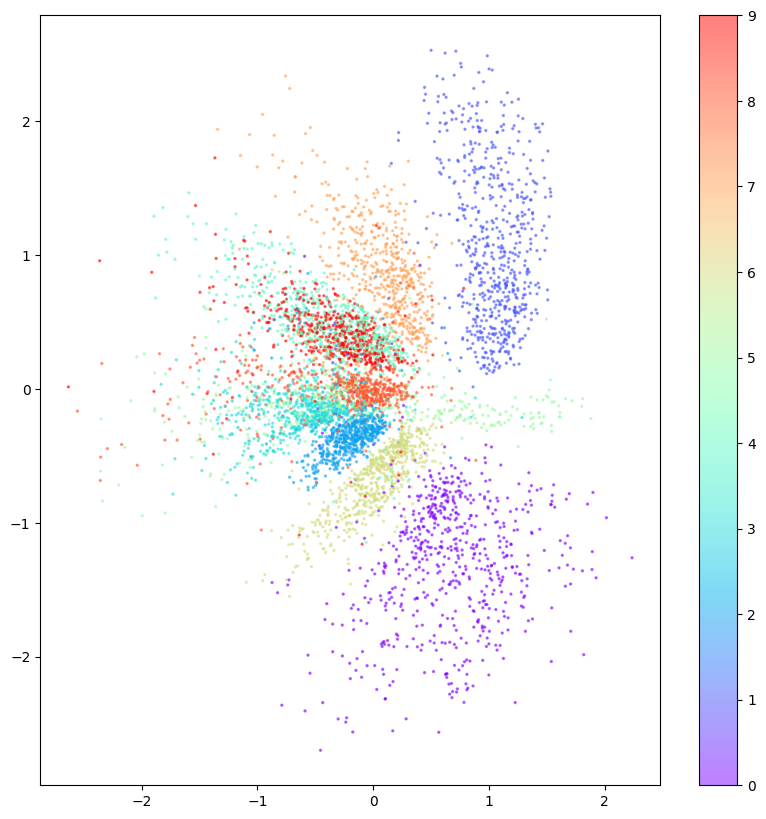

In [21]:
def select_images(ds, num_images=10):
    indices = random.sample(range(len(ds['train'])), num_images)
    sampled_dataset = ds['train'].select(indices)
    sampled_dataset = ImageDataset(sampled_dataset, transform=transform)
    sampled_dataset = DataLoader(sampled_dataset, batch_size=num_images, shuffle=True, num_workers=3, pin_memory=True)
    return sampled_dataset

def plot_reconstructed_images(images, reconstructed_images):
    fig = plt.figure(figsize=(15, 3))
    num_images = len(images)
    for i, (image, reconstructed_image) in enumerate(zip(images, reconstructed_images)):
        image = image.cpu().squeeze()
        ax = fig.add_subplot(2, num_images, i + 1)
        ax.axis("off")
        ax.imshow(image, cmap="gray_r")
        reconstructed_image = reconstructed_image.squeeze()
        ax = fig.add_subplot(2, num_images, i + num_images + 1)
        ax.axis("off")
        ax.imshow(reconstructed_image, cmap="gray_r")
    plt.show()

def plot_images_encoded_in_latent_space(latent_representations, sample_labels):
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_representations[:, 0],
                latent_representations[:, 1],
                cmap="rainbow",
                c=sample_labels,
                alpha=0.5,
                s=2)
    plt.colorbar()
    plt.show()

num_sample_images_to_show = 8
sample_images  = select_images(ds, num_sample_images_to_show)
sample_images = DeviceDataLoader(sample_images, device)
for images,labels in sample_images:
  with torch.no_grad():
    reconstructed_images,_,_ = model_ac(images)
    plot_reconstructed_images(images.cpu(), reconstructed_images.cpu().numpy())

num_images = 6000
sample_images = select_images(ds, num_images)
for images,labels in sample_images:
  images = images.to(device)
  with torch.no_grad():
    latent_representations = model_ac.proyectar(images)
    plot_images_encoded_in_latent_space(latent_representations.cpu().numpy(), labels)

In [32]:
def plot_generated_images(reconstructed_images):
    fig = plt.figure(figsize=(15, 3))
    num_images = len(images)
    for i, (reconstructed_image) in enumerate(reconstructed_images):
        reconstructed_image = reconstructed_image.squeeze()
        ax = fig.add_subplot(2, num_images, i + num_images + 1)
        ax.axis("off")
        ax.imshow(reconstructed_image, cmap="gray_r")
    plt.show()

##Images Generator

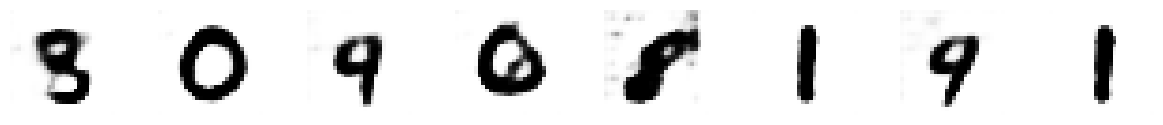

In [34]:
images = torch.randn((8,2))

with torch.no_grad():
  reconstructed_images = model_ac.decoder_step(images)
  plot_generated_images(reconstructed_images.cpu().numpy())